In [1]:
from pixel_interp import PixelInterpolator
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/jovyan/shared/data/ecopro/KelpForest/kelp_locations_unique_26_36.csv')
mur = xr.open_dataset('/home/jovyan/shared/data/ecopro/KelpForest/MUR_mon_200206-202001.nc')
lat, lon = np.meshgrid(mur.lat, mur.lon, indexing='ij')
pts = np.array(list(zip(lat.ravel(), lon.ravel())))
interp = PixelInterpolator(pts, df.values)

In [4]:
sst = np.array([interp(mur.analysed_sst.isel(time=i).values.astype('float32').ravel()) for i in range(mur.time.size)])
ds = xr.DataArray(sst.astype('float32'), dims=('time', 'pts'), name='analysed_sst').to_dataset()
ds = ds.assign_coords(lat=(('pts'), df.Latitude), 
                      lon=(('pts'), df.Longitude), 
                      time=mur.time)
clim = ds.analysed_sst.groupby('time.month').mean()
ds['analysed_sst_clim'] = clim

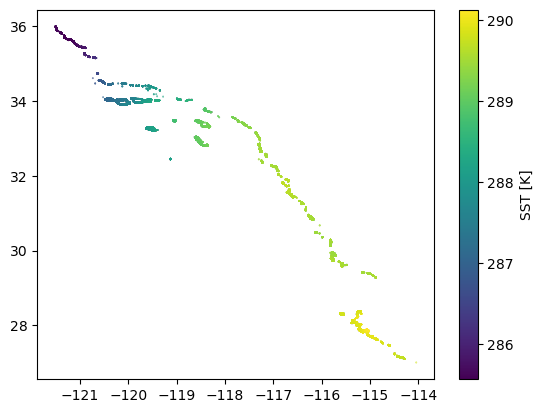

In [5]:
plt.scatter(ds.lon.values, ds.lat.values, c=ds.analysed_sst.isel(time=0).values, s=0.1)
plt.colorbar(label='SST [K]')

In [6]:
ds

<xarray.Dataset>
Dimensions:            (month: 12, pts: 416569, time: 212)
Coordinates:
    lat                (pts) float64 27.01 27.01 27.01 27.01 ... 35.99 36.0 36.0
    lon                (pts) float64 -114.0 -114.0 -114.0 ... -121.5 -121.5
  * time               (time) datetime64[ns] 2002-06-30 ... 2020-01-31
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: pts
Data variables:
    analysed_sst       (time, pts) float32 289.8 nan nan nan ... nan nan nan nan
    analysed_sst_clim  (month, pts) float32 291.5 nan nan nan ... nan nan nan

In [7]:
ds.to_netcdf('/home/jovyan/shared/data/ecopro/KelpForest/MUR_kelp_unique_26_36.nc',
             encoding=dict(analysed_sst=dict(zlib=True, complevel=5)))